In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import sys
# use code from https://github.com/CaloChallenge/homepage/blob/main/code/HighLevelFeatures.ipynb
sys.path.append("../homepage/code/")

from HighLevelFeatures import HighLevelFeatures as HLF
import numpy as np
import h5py
import matplotlib.pyplot as plt
from model import WGANGP

2022-12-12 00:20:46.807477: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-12 00:20:46.807493: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
# creating instance of HighLevelFeatures class to handle geometry based on binning file
input_path = '../input/dataset1'
HLF_1_photons = HLF('photon', filename=f'{input_path}/binning_dataset_1_photons.xml')

# loading the .hdf5 datasets
photon_file = h5py.File(f'{input_path}/dataset_1_photons_1.hdf5', 'r')

# each file contains one dataset for the incident energy and one for the showers.
for dataset in photon_file:
    # name of the datasets:
    print(f"dataset '{dataset}' has {photon_file[dataset][:].shape[0]} events, each with dimension of {photon_file[dataset][:].shape[1]}")


dataset 'incident_energies' has 121000 events, each with dimension of 1
dataset 'showers' has 121000 events, each with dimension of 368


Create a condition label using the kinetic energy. The relativistic relation between kinetic energy and momentum is given by [ref](https://en.wikipedia.org/wiki/Kinetic_energy)

$$E_k = \sqrt{p^2 + m^2} - m$$

Label is normalised by LogE, ie

$$Lable (E_k) = \frac{log\frac{E_k}{E_{k, min}}}{log\frac{E_{k, max}}{E_{k, min}}} $$

In [4]:
def particle_mass(particle=None):
    if 'photon' in particle or particle == 22:
        mass = 0
    elif 'electron' in particle or particle == 11:
        mass = 0.512
    elif 'pion' in particle or particle == 211:
        mass = 139.6
    elif 'proton' in particle or particle == 2212:
        mass = 938.27
    return mass

def kin_to_label(kin):
    kin_min = np.min(kin)
    kin_max = np.max(kin)
    return np.log(kin / kin_min) / np.log(kin_max / kin_min)

mass = particle_mass(HLF_1_photons.particle)
kin = np.sqrt( np.square(photon_file['incident_energies'][:]) + np.square(mass) ) - mass
label_kin = kin_to_label(kin)

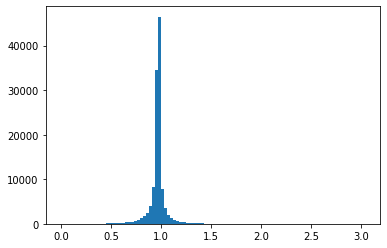

In [5]:
X_train = photon_file['showers'][:] / kin
_ = plt.hist(X_train.sum(axis=1), bins=100)

(array([3.1000e+01, 9.0000e+00, 6.0000e+00, 5.0000e+00, 4.0000e+00,
        1.0000e+01, 1.0000e+01, 1.7000e+01, 2.9000e+01, 1.8000e+01,
        3.4000e+01, 2.6000e+01, 4.2000e+01, 5.8000e+01, 6.0000e+01,
        7.5000e+01, 9.7000e+01, 1.0200e+02, 1.5200e+02, 1.9000e+02,
        2.8000e+02, 2.9900e+02, 4.3500e+02, 4.8500e+02, 6.5200e+02,
        9.2900e+02, 1.1910e+03, 1.7380e+03, 2.4820e+03, 4.0490e+03,
        8.2410e+03, 3.4531e+04, 4.6479e+04, 7.8250e+03, 3.5370e+03,
        2.0860e+03, 1.3590e+03, 9.3300e+02, 6.4600e+02, 4.6900e+02,
        3.6700e+02, 2.7200e+02, 1.6900e+02, 1.1300e+02, 9.2000e+01,
        8.4000e+01, 6.8000e+01, 4.2000e+01, 2.5000e+01, 2.9000e+01,
        2.1000e+01, 2.3000e+01, 1.1000e+01, 1.0000e+01, 1.0000e+01,
        8.0000e+00, 5.0000e+00, 2.0000e+00, 2.0000e+00, 3.0000e+00,
        3.0000e+00, 5.0000e+00, 2.0000e+00, 2.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 3.0000e+00,
        0.0000e+00, 1.0000e+00, 1.0000e+00, 0.00

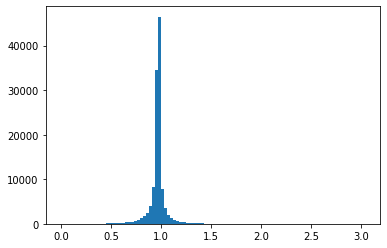

In [7]:
ratio = photon_file['showers'][:].sum(axis=1).reshape(-1,1) / photon_file['incident_energies'][:]
plt.hist(ratio, bins=100)

In [8]:
# HLF_1_photons.CalculateFeatures(photon_file["showers"][:])
# print("Total energy of each photon shower: ", HLF_1_photons.GetEtot())

# # energy deposited in each layer of the geometry:
# # (returns a dict with layer_number as key. Note that the ATLAS geometry has fewer relevant layer than are totally
# # available, the 5th layer of the photons therefore has layer_number 12)
# print("Energy deposited in each layer for each photon shower: ", HLF_1_photons.GetElayers())
# # print("Average energy deposited in the first layer for pion showers: ", HLF_1_pions.GetElayers()[0].mean())
# # print("Average energy deposited in the last layer for pion showers: ", HLF_1_pions.GetElayers()[14].mean())


# # # Center of energy in eta direction:
# # # (only available for layer with more than one alpha bin)
# # print("Center of energy in eta direction for each photon shower: ", HLF_1_photons.GetECEtas())
# # # and its width
# # print("Width of center of energy in eta direction for each photon shower: ", HLF_1_photons.GetWidthEtas())

# # # Center of energy in phi direction:
# # # (only available for layer with more than one alpha bin)
# # print("Center of energy in phi direction for each pion shower: ", HLF_1_pions.GetECPhis())
# # # and its width
# # print("Width of center of energy in phi direction for each pion shower: ", HLF_1_pions.GetWidthEtas())


In [33]:
hp_config = {
    'model': 'BNswish',
    'G_size': 1,
    'D_size': 1,
    'G_lr': 1E-4,
    'D_lr': 1E-4,
    'G_beta1': 0.5,
    'G_beta1': 0.5,
    'batchsize': 512,
    'dgratio': 5,
    'latent_dim': 50,
    'lam': 3,
    'conditional_dim': label_kin.shape[1],
    'generatorLayers': [50, 100, 200],
    'nvoxels': 368,
    'use_bias': True,
}

job_config = {
    'particle': 'photons',
    'eta_slice': '20_25',
    'checkpoint_interval': 2,
    'output': '../output/dataset1/v1',
    'max_iter': 16,
    'cache': True,
}

wgan = WGANGP(job_config=job_config, hp_config=hp_config)

Use model BNswish
Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Noise (InputLayer)              [(None, 50)]         0                                            
__________________________________________________________________________________________________
mycond (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
concatenate_8 (Concatenate)     (None, 51)           0           Noise[0][0]                      
                                                                 mycond[0][0]                     
__________________________________________________________________________________________________
dense_64 (Dense)                (None, 50)           2600        concatena

Iter: 0 skip, load ../output/dataset1/v1/photons_eta_20_25/checkpoints/model-1
Iter: 2 skip, load ../output/dataset1/v1/photons_eta_20_25/checkpoints/model-2
Iter: 4 skip, load ../output/dataset1/v1/photons_eta_20_25/checkpoints/model-3
Iter: 6 skip, load ../output/dataset1/v1/photons_eta_20_25/checkpoints/model-4
Iter: 8 skip, load ../output/dataset1/v1/photons_eta_20_25/checkpoints/model-5
Iter: 10 skip, load ../output/dataset1/v1/photons_eta_20_25/checkpoints/model-6
Iter: 12 skip, load ../output/dataset1/v1/photons_eta_20_25/checkpoints/model-7
Iter: 14 skip, load ../output/dataset1/v1/photons_eta_20_25/checkpoints/model-8
Iter: 16; D loss: -0.1563; G_loss: 0.0764; TotalTime: 6.1046; TrainLoop: 1.5743, Save: 1.333
> /afs/cern.ch/work/z/zhangr/FCG/FastCaloChallenge/training/model.py(299)plot_loss()
    297         ax.cla()
    298         set_trace()
--> 299         ax.plot(meta_data['Iteration'], meta_data['Gloss'], label="Generator")
    300         ax.plot(meta_data['Iteration'],

ipdb> c
Save to ../output/dataset1/v1/photons_eta_20_25/train/loss.pdf


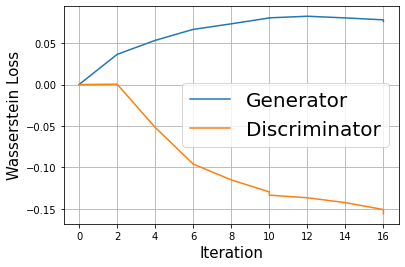

In [34]:
wgan.train(X_train, label_kin)